### Data Analyst Assignmennt Step1 

Company is launching new wifi faetures and wants to understand the impact on devices when bands are switched from 2.4GHz and 5GHz respectively.

Evalaute the Phy Rate at different RSSI Level


In [1]:
# load the librabries
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import count, col
from pyspark.sql.functions import col, skewness, kurtosis

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create a Spark context
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

In [3]:
## Loading the data form part1 client sample amd reading it to a dataframe
df = sqlContext.read.format("csv").option("header","true").load('client_stats_sample_0225part1.csv')

In [4]:
# how many rows are there in dataset
df.count()

350000

In [5]:
# What is the schema of dataframe
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- location_id: string (nullable = true)
 |-- client_mac: string (nullable = true)
 |-- freq_band: string (nullable = true)
 |-- mac_address: string (nullable = true)
 |-- country: string (nullable = true)
 |-- vendor_name: string (nullable = true)
 |-- rssi_percs_25: string (nullable = true)
 |-- rssi_percs_75: string (nullable = true)
 |-- isp: string (nullable = true)
 |-- total_bytes_tx: string (nullable = true)
 |-- total_bytes_rx: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- txWeightedPhyRate: string (nullable = true)
 |-- rxWeightedPhyRate: string (nullable = true)
 |-- idtype: string (nullable = true)
 |-- is_static: string (nullable = true)
 |-- weighted_prr_tx: string (nullable = true)
 |-- weighted_prr_rx: string (nullable = true)
 |-- num_samples: string (nullable = true)
 |-- is_connected_to_pod: string (nullable = true)
 |-- pod_serial: string (nullable = true)
 |-- control_group: string (nullable = true)
 |-- b

In [6]:
# _c0 is a noise in the data, so we need to drop it
df =df.drop("_c0")

In [7]:
# Are there null values in dataset. Which columns has how many null values
# this is very important 
null_value_counts = {i:df.filter(df[i].isNull()).count() for i in df.columns}
null_value_counts

{'bandCap2G': 21164,
 'bandCap5G': 21164,
 'client_mac': 0,
 'control_group': 329419,
 'country': 880,
 'freq_band': 0,
 'idtype': 22028,
 'isBTMSupported': 21164,
 'is_connected_to_pod': 0,
 'is_static': 220841,
 'isp': 880,
 'location_id': 0,
 'mac_address': 0,
 'maxChWidth': 21164,
 'maxMcs': 21164,
 'maxNss': 21164,
 'num_samples': 0,
 'phyMode': 21164,
 'pod_serial': 349731,
 'rssi_percs_25': 367,
 'rssi_percs_75': 367,
 'rxWeightedPhyRate': 4686,
 'total_bytes_rx': 4686,
 'total_bytes_tx': 12342,
 'ts': 0,
 'txWeightedPhyRate': 12342,
 'vendor_name': 217871,
 'weighted_prr_rx': 4686,
 'weighted_prr_tx': 12342}

#### Features of interest
We need to understand the relationship between RSSI and Phy Rate so we will select only relevant features to move forward

In [8]:
### Select faetures of interest for analysis as descbied in problem
df_select = df.select("rssi_percs_25", 'rxWeightedPhyRate', 'txWeightedPhyRate')
df_select.show()

+-------------+-----------------+-----------------+
|rssi_percs_25|rxWeightedPhyRate|txWeightedPhyRate|
+-------------+-----------------+-----------------+
|        -64.0|         85.17462|         88.45363|
|        -64.0|       116.114296|        125.81183|
|        -64.0|        97.602585|       113.710815|
|        -64.0|         93.59775|         98.49928|
|        -60.0|        64.956215|        50.702835|
|        -61.0|         63.83611|        50.534744|
|        -61.0|        61.104904|        49.119404|
|        -59.0|           64.735|        54.749767|
|        -58.0|         72.22222|         72.22222|
|        -57.0|         57.91453|        72.085495|
|        -58.0|         72.22222|         72.22221|
|        -58.0|         72.22222|         72.22221|
|        -47.0|         67.61316|         72.22222|
|        -43.0|        36.386463|         72.22207|
|        -43.0|        51.480503|         72.22222|
|        -45.0|         67.04335|         72.22222|
|        -63

In [9]:
## Let us understand the disctribution of columns for selected dataframe
for i in df_select.columns:
    print("This is the value counts for", i)
    df_select.groupBy(i).count().show(5)

This is the value counts for rssi_percs_25
+-------------+-----+
|rssi_percs_25|count|
+-------------+-----+
|        -93.0|    4|
|        -73.0| 6259|
|         -7.0|   15|
|        -18.0|  323|
|        -62.0|11313|
+-------------+-----+
only showing top 5 rows

This is the value counts for rxWeightedPhyRate
+-----------------+-----+
|rxWeightedPhyRate|count|
+-----------------+-----+
|        44.789726|    1|
|         34.93622|    1|
|         70.48624|    2|
|        149.64243|    1|
|        373.27084|    1|
+-----------------+-----+
only showing top 5 rows

This is the value counts for txWeightedPhyRate
+-----------------+-----+
|txWeightedPhyRate|count|
+-----------------+-----+
|        382.41983|    1|
|         93.82679|    1|
|         8.618103|    1|
|        153.86679|    1|
|         708.3972|    1|
+-----------------+-----+
only showing top 5 rows



In [10]:
# Are there null values in selected faetures. Which columns has how many null values
# this is very important 
null_value_counts_selected = {i:df_select.filter(df_select[i].isNull()).count() for i in df_select.columns}
null_value_counts_selected

{'rssi_percs_25': 367, 'rxWeightedPhyRate': 4686, 'txWeightedPhyRate': 12342}

In [11]:
# Let us drop the values which we have missing values 
# We can also use imputation method 
df_select = df_select.dropna(how='any')

#### Caution - Conversion to Pandas DataFrame is very inefficient but we can see the histogram here

In [12]:
# convert to pandas to plot
pdf = df_select.toPandas()

In [13]:
# check if all data in good after conversion
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336064 entries, 0 to 336063
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   rssi_percs_25      336064 non-null  object
 1   rxWeightedPhyRate  336064 non-null  object
 2   txWeightedPhyRate  336064 non-null  object
dtypes: object(3)
memory usage: 7.7+ MB


In [14]:
# convert values to numeric 
cols = pdf.columns
pdf[cols] = pdf[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [15]:
### Dropn na values
pdf = pdf.dropna()

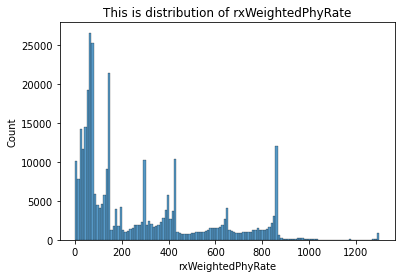

In [16]:
# plot for histgram for rxWeightedPhyRate
plt.title("This is distribution of rxWeightedPhyRate")
sns.histplot(pdf['rxWeightedPhyRate'])
plt.show()

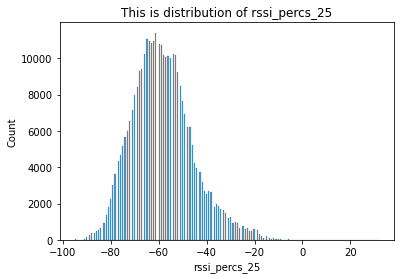

In [17]:
# plot for histgram for rssi_percs_25
plt.title("This is distribution of rssi_percs_25")
sns.histplot(pdf['rssi_percs_25'])    
plt.show()

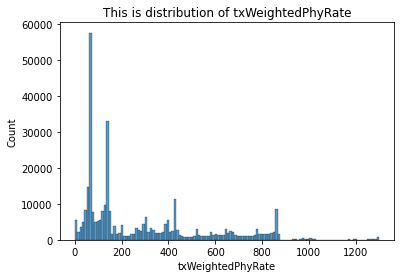

In [18]:
# plot for histgram for txWeightedPhyRate
plt.title("This is distribution of txWeightedPhyRate")
sns.histplot(pdf['txWeightedPhyRate'])
plt.show()

#### Produce a histgram for average of tx and rx weighted phy rate between -85 and -65 db in 1 db steps

In [19]:
# Create a new dataframe with the given condition
conditional_df = (pdf[pdf['rssi_percs_25'].between(-85, -65, inclusive=True)]).\
        groupby('rssi_percs_25')['rxWeightedPhyRate', 'txWeightedPhyRate', 'rssi_percs_25'].\
        mean()

C:\Users\ankit.t\AppData\Local\conda\conda\envs\my_root\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [20]:
# Let us validate the aggrgated values
print("The shape of the dataframe", conditional_df.shape)

The shape of the dataframe (21, 3)


In [21]:
# print the complete dataframe 
conditional_df.head(30)

,rxWeightedPhyRate,txWeightedPhyRate,rssi_percs_25
rssi_percs_25,,,
-85.0,20.724570,41.772198,-85.0
-84.0,22.531496,45.422143,-84.0
-83.0,30.234468,62.029376,-83.0
-82.0,37.133368,77.736202,-82.0
-81.0,46.297916,100.945095,-81.0
-80.0,50.932706,97.809913,-80.0
-79.0,55.780964,100.486527,-79.0
-78.0,62.026563,102.941965,-78.0
-77.0,70.152202,107.798517,-77.0


### We have 21 values 

## Histogram for columns 

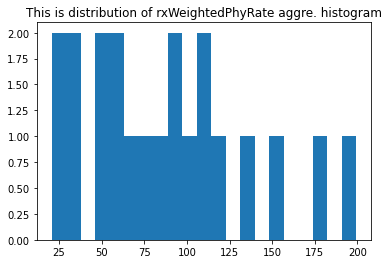

In [22]:
# plot histogram for the output -rxWeightedPhyRate
plt.title("This is distribution of rxWeightedPhyRate aggre. histogram")
num_bins = 21
n, bins, patches = plt.hist(conditional_df['rxWeightedPhyRate'], num_bins)
plt.show()

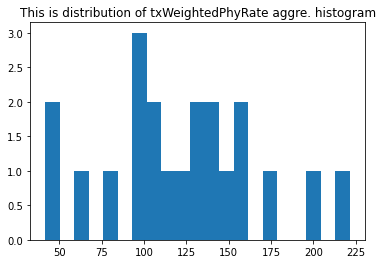

In [23]:
# plot histogram for the output -rxWeightedPhyRate
plt.title("This is distribution of txWeightedPhyRate aggre. histogram")
num_bins = 21
n, bins, patches = plt.hist(conditional_df['txWeightedPhyRate'], num_bins)
plt.show()

C:\Users\ankit.t\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


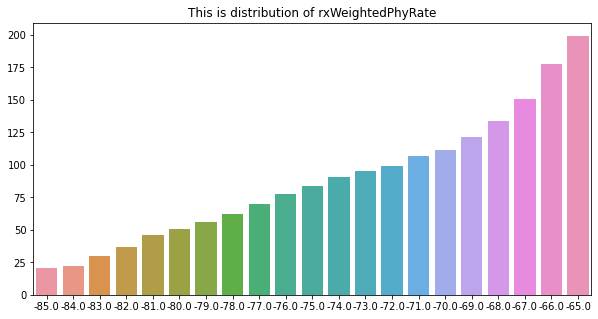

In [24]:
## ready for graph
x = conditional_df['rssi_percs_25'].values.tolist()
y = conditional_df['rxWeightedPhyRate'].values.tolist()

# plot for histgram for rxWeightedPhyRate
plt.figure(figsize=(10, 5))
plt.title("This is distribution of rxWeightedPhyRate")
sns.barplot(x, y)
plt.show()

C:\Users\ankit.t\AppData\Local\conda\conda\envs\my_root\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


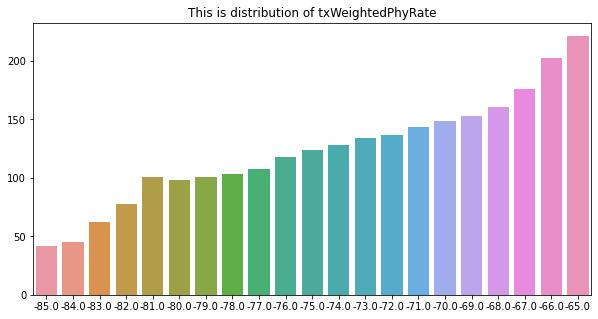

In [25]:
## ready for graph
x = conditional_df['rssi_percs_25'].values.tolist()
y = conditional_df['txWeightedPhyRate'].values.tolist()

# plot for histgram for txWeightedPhyRate
plt.figure(figsize=(10, 5))
plt.title("This is distribution of txWeightedPhyRate")
sns.barplot(x, y)
plt.show()

#### Data Export 
### Data export to csv for logstash >> ElasticSearch >> Grafana

In [26]:
# Data export to csv 
conditional_df.to_csv("data_for_logstash.csv")

### Next steps

### Missing values Treatment
All features are having missing values, SO we need to include imputation method for these values 

Before taking a decision, let us look upon the statistical properties of the dataset 

In [27]:
df_select.describe().show()

+-------+------------------+------------------+-----------------+
|summary|     rssi_percs_25| rxWeightedPhyRate|txWeightedPhyRate|
+-------+------------------+------------------+-----------------+
|  count|            336064|            336064|           336064|
|   mean|-58.37236062178633|268.36373403396084|285.7291826124183|
| stddev|12.709362017567964| 270.4578811967436|268.5928210988447|
|    min|             -10.0|               0.0|              0.0|
|    max|              32.0|         999.54034|         999.9521|
+-------+------------------+------------------+-----------------+



## As output of the last function shows, we can take below decisions
1. rssi_percs_25 - This  feature needs to imputed with median 
2. rxWeightedPhyRate and txWeightedPhyRate can be imputed with mean values

In [28]:
# perform more tests and check the properties
df_select.select(skewness("rxWeightedPhyRate"),kurtosis("rxWeightedPhyRate")).show()

+---------------------------+---------------------------+
|skewness(rxWeightedPhyRate)|kurtosis(rxWeightedPhyRate)|
+---------------------------+---------------------------+
|         1.1461276845505461|         0.3103299329132323|
+---------------------------+---------------------------+

